# The Use of Grided $\mathsf{\delta^{18}O}$ Data

In [1]:
import sys
sys.path.insert(0, '_libs/')

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import InterpolatedUnivariateSpline
% matplotlib inline

In [3]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [4]:
def plot_d18O(nav_lon, nav_lat, d18O_masked, lev, cmap, ax):
    proj=Basemap(projection='npstere', resolution='c', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
    x, y=proj(nav_lon, nav_lat)
    # Ba
    CS=proj.contourf(x, y, d18O_masked, lev, cmap=cmap, extend='both')
    proj.contour(x, y, d18O_masked, lev, linewidths=1.5, colors=('gray',))
    # Frame
    proj.plot(x.T, y.T, color='k', linestyle='-', linewidth=0.01, alpha=0.25)
    proj.plot(x, y, color='k', linestyle='-', linewidth=0.01, alpha=0.25)
    return CS

# Read data

**Grided d18O data**

In [16]:
name = glob.glob('_data/calculated_d18O_v1_1.nc')
d18O_obj = nc.Dataset(name[0])
MAT=scipy.io.loadmat('_data/Exchange/d18O.mat')
d18O=MAT['d18O_ORCA2']

In [5]:
#d18O = d18O_obj.variables['d18o'][:]
y = d18O_obj.variables['lat'][:]
x = d18O_obj.variables['lon'][:]
depth = d18O_obj.variables['depth'][:]

In [6]:
lon, lat = np.meshgrid(x, y)

**My estimation**

In [7]:
MAT=scipy.io.loadmat('_data/Exchange/Temp_d18O_int.mat')
d18O_int = MAT['d18O_ini_xy'][:]
x = np.linspace(-180, 180, 360)
y = np.linspace(60, 90, 30)
lon_int, lat_int = np.meshgrid(x, y)

# Plot

In [8]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [9]:
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

In [10]:
clevs=[1000, 2000, 3000]

F:\Anaconda\lib\site-packages\matplotlib\colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


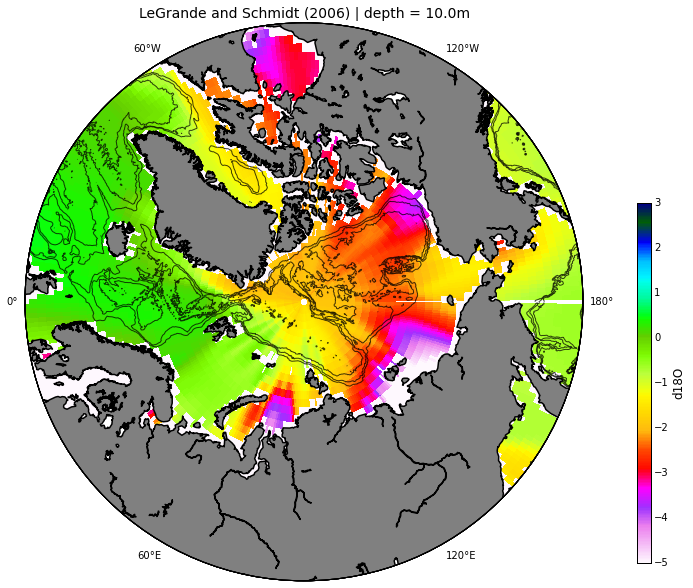

In [11]:
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(lon, lat)
topox, topoy = proj(lon_arctic, lat_arctic)
CS = proj.pcolor(x, y, d18O[:, :, 1], vmin=-5, vmax=3, cmap=plt.cm.gist_ncar_r)
CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
CS2.collections[0].set_label('1, 2, 3 km bathymetry')
cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.5]) 
CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
CBar.set_label('d18O', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
ax.set_title('LeGrande and Schmidt (2006) | depth = 10.0m', fontsize=14)

<img src="_figures/d18O.png" width=550 align="left"/>

# Remap to ORCA2

In [12]:
d18O.shape

(180L, 360L, 33L)

In [13]:
nc_name=glob.glob('_data/*_1m_*_ptrc_T.nc')
nc_obj=nc.Dataset(nc_name[0])
deptht = nc_obj.variables['deptht'][:]
nav_lon = nc_obj.variables['nav_lon'][:]
nav_lat = nc_obj.variables['nav_lat'][:]

In [22]:
deptht.shape

(31L,)

In [23]:
d18O_orca=np.empty([31, 149, 182])
for i in range(31):
    int_temp_orca = reporj_NEMOgrid(lon, lat, d18O[:, :, i], nav_lon, nav_lat, method='linear')   
    int_temp_mask = reporj_NEMOgrid(lon, lat, d18O[:, :, i], nav_lon, nav_lat, method='nearest')
    #int_temp_mask[np.isnan(int_temp_mask)]=-6.0
    int_temp_orca[np.isnan(int_temp_orca)] = int_temp_mask[np.isnan(int_temp_orca)]
    d18O_orca[i, :, :] = int_temp_orca

In [24]:
d18O_ini_masked = np.ma.masked_where(np.isnan(d18O_orca), d18O_orca)

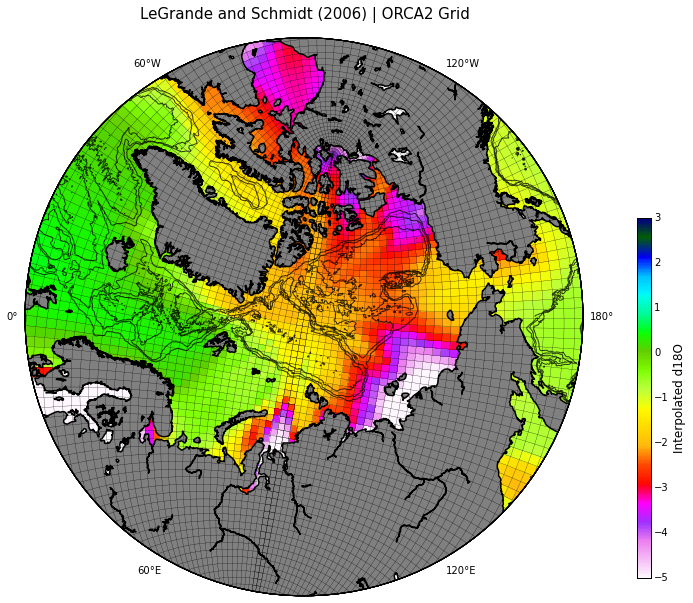

In [25]:
clevs=[1000, 2000, 3000]
for num in range(1):
    # Figures
    fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    gridx, gridy = proj(nav_lon, nav_lat)
    topox, topoy = proj(lon_arctic, lat_arctic)
    CS = proj.pcolor(gridx, gridy, d18O_ini_masked[num, :, :], vmin=-5, vmax=3, cmap=plt.cm.gist_ncar_r)
    CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
    CS2.collections[0].set_label('1, 2, 3 km bathymetry')
    proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
    proj.plot(gridx, gridy, 'k-', lw=0.25)
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.5]) 
    CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
    CBar.set_label('Interpolated d18O', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    ax.set_title('LeGrande and Schmidt (2006) | ORCA2 Grid', fontsize=15, y=1.025)

In [ ]:
save_var = { 'd18O_grid_orca': d18O_orca, 'nav_lon': nav_lon, 'nav_lat': nav_lat}
scipy.io.savemat('_data/Exchange/NEMO_ORCA2_d18O_Grid.mat', mdict=save_var)

In [12]:
boundary_name=glob.glob('_data/Exchange/TRC_BOUND.mat')
Boundary_Mat=scipy.io.loadmat(boundary_name[0])
domain=Boundary_Mat['domain']

In [6]:
MAT=scipy.io.loadmat('_data/Exchange/NEMO_ORCA2_d18O_Grid.mat')
d18O_ini = MAT['d18O_grid_orca']
nav_lon = MAT['nav_lon']
nav_lat = MAT['nav_lat']

In [8]:
name = glob.glob('_data/*GRID01*')
grid_obj = nc.Dataset(name[0])

In [14]:
d18O = grid_obj['d18O']
Ba = grid_obj['Ba']

In [19]:
L=0
lev1 = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5]
lev2 = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]
d18O_Jan = np.ma.masked_where(((domain==0) | (Ba[24, L, :, :]==0)), d18O[24, L, :, :])
d18O_Apr = np.ma.masked_where(((domain==0) | (Ba[27, L, :, :]==0)), d18O[27, L, :, :])
d18O_Jul = np.ma.masked_where(((domain==0) | (Ba[30, L, :, :]==0)), d18O[30, L, :, :])
d18O_Oct = np.ma.masked_where(((domain==0) | (Ba[33, L, :, :]==0)), d18O[30, L, :, :])

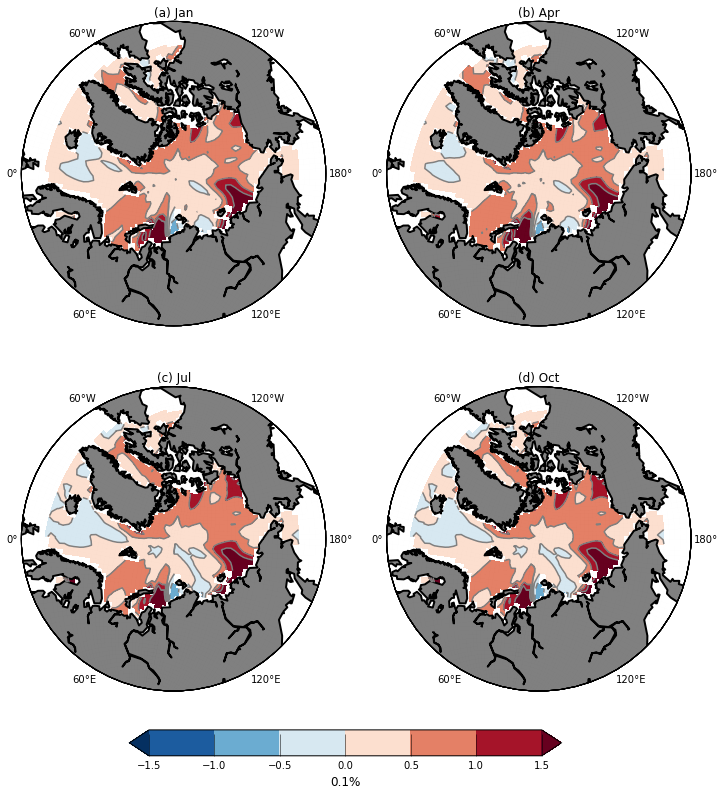

In [22]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)

CS1 = plot_d18O(nav_lon, nav_lat, d18O_Jan-d18O_ini[L, :, :], lev2, plt.cm.RdBu_r, ax1)
CS2 = plot_d18O(nav_lon, nav_lat, d18O_Apr-d18O_ini[L, :, :], lev2, plt.cm.RdBu_r, ax2)
CS3 = plot_d18O(nav_lon, nav_lat, d18O_Jul-d18O_ini[L, :, :], lev2, plt.cm.RdBu_r, ax3)
CS4 = plot_d18O(nav_lon, nav_lat, d18O_Oct-d18O_ini[L, :, :], lev2, plt.cm.RdBu_r, ax4)
# Title
ax1.set_title('(a) Jan'); ax2.set_title('(b) Apr')
ax3.set_title('(c) Jul'); ax4.set_title('(d) Oct')
# cbar
cax2  = fig.add_axes([0.25, 0.05, 0.5, 0.03])
CBar2 = fig.colorbar(CS2, cax=cax2, orientation='horizontal')
CBar2.set_label('0.1%', fontsize=12)
CBar2.ax.tick_params(axis='x', length=22)
CBar2.set_ticks(lev2)

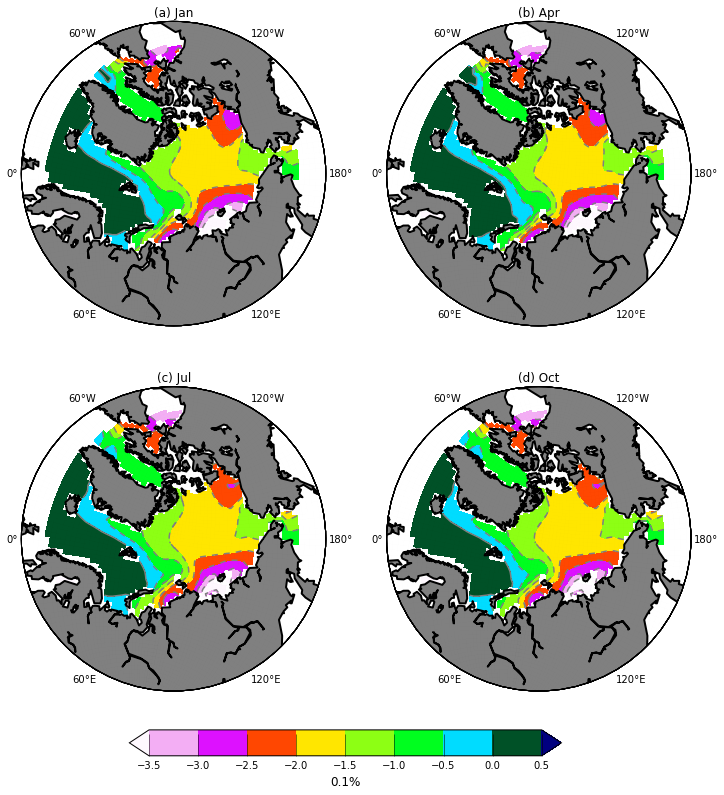

In [23]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)

CS1 = plot_d18O(nav_lon, nav_lat, d18O_Jan, lev1, plt.cm.gist_ncar_r, ax1)
CS2 = plot_d18O(nav_lon, nav_lat, d18O_Apr, lev1, plt.cm.gist_ncar_r, ax2)
CS3 = plot_d18O(nav_lon, nav_lat, d18O_Jul, lev1, plt.cm.gist_ncar_r, ax3)
CS4 = plot_d18O(nav_lon, nav_lat, d18O_Oct, lev1, plt.cm.gist_ncar_r, ax4)
# Title
ax1.set_title('(a) Jan'); ax2.set_title('(b) Apr')
ax3.set_title('(c) Jul'); ax4.set_title('(d) Oct')
# cbar
cax2  = fig.add_axes([0.25, 0.05, 0.5, 0.03])
CBar2 = fig.colorbar(CS2, cax=cax2, orientation='horizontal')
CBar2.set_label('0.1%', fontsize=12)
CBar2.ax.tick_params(axis='x', length=22)
CBar2.set_ticks(lev1)